## Application Project - Emotions (Group 30)

This project discusses the research question: “How can topic modeling and sentiment analysis utilize journal entries to provide an overview of a group’s welfare?”

In [6]:
#import everything
import gensim
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np
import re
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import nltk
import string
import re
import bs4
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from wordcloud import WordCloud
import pickle

#import files in google colab, because in this project Google Colab has been used because of GPU
from google.colab import files
uploaded = files.upload()

print('Import compete')

Import compete


In [7]:
#datasets
training_data= pd.read_csv('/content/train.txt', header =None, sep =';', encoding='utf-8')
validation_data = pd.read_csv('/content/val.txt', header = None, sep =';', encoding='utf-8')
test_data = pd.read_csv('/content/test.txt', header = None, sep =';', encoding='utf-8')

In [8]:
#print shape of raw training data
print(training_data.shape)

#check raw training data
training_data.head(5)

(16000, 2)


,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Preprocessing 

In this section the dataset will be preprocessed

In [9]:
#Give the columns of the training data names
training_data.columns =['Input', 'Sentiment']

#print shape of updated training data
print(training_data.shape)

#check the updated training data out
training_data.head(5)

(16000, 2)


,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [10]:
#print shape of raw test data
print(test_data.shape)

#check raw test data
test_data.head(5)

(2000, 2)


,0,1
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [11]:
#Give the columns of the training data names
test_data.columns =['Input', 'Sentiment']

#Give the columns of the validation data names
validation_data.columns =['Input', 'Sentiment']

#print shape of updated test data
print(test_data.shape)

#check the updated test data out
test_data.head(5)

(2000, 2)


,Input,Sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [12]:
#print the number of empty values
empty_values_amount_training = training_data.isna().sum()
empty_values_amount_test = test_data.isna().sum()
empty_values_amount_val = validation_data.isna().sum()
print(empty_values_amount_training)  
print('\n')
print(empty_values_amount_test) 
print('\n')

Input        0
Sentiment    0
dtype: int64


Input        0
Sentiment    0
dtype: int64




In [13]:
#print the number of duplicates
duplicates_training = training_data.duplicated().sum()
duplicates_test = training_data.duplicated().sum()
duplicates_validation = validation_data.isna().sum()
print('The number of duplicates for the training data is:', duplicates_training)  
print('\n')
print('The number of duplicates for the test data is:', duplicates_test)  
print('\n')

The number of duplicates for the training data is: 1


The number of duplicates for the test data is: 1




In [14]:
#remove remaining duplicates
training_data.drop_duplicates(subset = "Input", keep = False, inplace = True)
new_updated_duplicates_training= training_data.duplicated().sum()
test_data.drop_duplicates(subset = "Input", keep = False, inplace = True)
new_updated_duplicates_test= test_data.duplicated().sum()
new_updated_duplicates_val = validation_data.duplicated().sum()

#print the updated number of duplicates
print('The number of duplicated for the training data is:', new_updated_duplicates_training)
print('\n')
print('The number of duplicated for the test data is:', new_updated_duplicates_test)
print('\n')

The number of duplicated for the training data is: 0


The number of duplicated for the test data is: 0




In [15]:
#postagging

def obtain_the_pos_wordnet(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
#preprocessing of the dataset

def preproccesing(text):
    #lowe case
    text = text.lower()
    
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove stop words
    stop = stopwords.words('english')+['wont', 'thing','wouldnt', 'shouldnt', 'couldnt', 'cudnt','cant', 'cant', 'dont', 'doesnt', 'didnt', 'wasnt','werent', 'havent', 'hadnt', 'n\t', '\re', '\s', "\d ", "\ ll ", '\dunno', 'ive', 'im', 'i m', 'w', 'make', 'know', 'like', 'think', 'want', 'look', 'http', 'href', 'little', 'feeling','really', 'feel', 'need', 'make', 'long', 'felt' ]
    text = [x for x in text if x not in stop]
    
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # pos tag text (function in above cell)
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], obtain_the_pos_wordnet(t[1])) for t in pos_tags]
    
    #only select words with characters more than 3
    text = [t for t in text if len(t) > 3]
    
    # join all
    text = " ".join(text)
    
    #return the text
    return(text)

In [17]:
#apply preprocessing

training_data["Input"] = training_data["Input"].apply(lambda x: preproccesing(x))
test_data["Input"] = test_data["Input"].apply(lambda x: preproccesing(x))
validation_data["Input"] = validation_data["Input"].apply(lambda x: preproccesing(x))

In [18]:
#remove certain words

def remove_words(phrase):
    
    phrase = re.sub("feeling", " ", phrase)
    phrase = re.sub("make", " ", phrase)
    phrase = re.sub("come", " ", phrase)
    phrase = re.sub("feel", " ", phrase)
    phrase = re.sub("thing", " ", phrase)

  
    return phrase

In [19]:
#apply the removal of the words to the different datasets

training_data["Input"] = training_data["Input"].apply(lambda x: remove_words(x))
test_data["Input"] = test_data["Input"].apply(lambda x: remove_words(x))
validation_data["Input"] = validation_data["Input"].apply(lambda x: remove_words(x))

In [20]:
#check it out
training_data_preprocessed = training_data
training_data_preprocessed.head()

,Input,Sentiment
0,humiliate,sadness
1,hopeless damn hopeful around someone care awake,sadness
2,grab minute post greedy wrong,anger
3,ever nostalgic fireplace still property,love
4,grouchy,anger


In [21]:
#check it out
validation_data_preprocessed = validation_data
validation_data_preprocessed.head()

,Input,Sentiment
0,quite sorry snap soon,sadness
1,still look blank canvas blank piece paper,sadness
2,faithful servant,love
3,cranky blue,anger
4,treat festive,joy


In [22]:
#check it out
test_data_preprocessed = test_data
test_data_preprocessed.head()

,Input,Sentiment
0,rather rotten ambitious right,sadness
1,update blog shitty,sadness
2,never separate ever ashamed,sadness
3,leave bouquet yellow tulip slightly optimistic...,joy
4,vain,sadness


In [23]:
#count the number of values for each sentiment in the training data.
training_data_preprocessed.Sentiment.value_counts()

joy         5344
sadness     4662
anger       2152
fear        1926
love        1289
surprise     565
Name: Sentiment, dtype: int64

In [24]:
#count the number of values for each sentiment in the training data.
validation_data_preprocessed.Sentiment.value_counts()

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: Sentiment, dtype: int64

In [25]:
#count the number of values for each sentiment in the training data.
test_data_preprocessed.Sentiment.value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Sentiment, dtype: int64

In [26]:
#change the label of the sentiment to a number (training data)

def change_label(training_data_preprocessed):
    training_data_preprocessed.replace(to_replace = "sadness", value = 0, inplace = True)
    training_data_preprocessed.replace(to_replace = "joy", value = 1, inplace = True)
    training_data_preprocessed.replace(to_replace = "surprise", value = 2, inplace = True)
    training_data_preprocessed.replace(to_replace = "love", value = 3, inplace = True)
    training_data_preprocessed.replace(to_replace = "anger", value = 4, inplace = True)
    training_data_preprocessed.replace(to_replace = "fear", value = 5, inplace = True)

In [27]:
#apply to the training data 

change_label(training_data_preprocessed['Sentiment'])

In [28]:
#check it out

training_data_preprocessed.head(5)

,Input,Sentiment
0,humiliate,0
1,hopeless damn hopeful around someone care awake,0
2,grab minute post greedy wrong,4
3,ever nostalgic fireplace still property,3
4,grouchy,4


In [29]:
#change the label of the sentiment to a number (validation data)

def change_label_val(validation_data_preprocessed):
    validation_data_preprocessed.replace(to_replace = "sadness", value = 0, inplace = True)
    validation_data_preprocessed.replace(to_replace = "joy", value = 1, inplace = True)
    validation_data_preprocessed.replace(to_replace = "surprise", value = 2, inplace = True)
    validation_data_preprocessed.replace(to_replace = "love", value = 3, inplace = True)
    validation_data_preprocessed.replace(to_replace = "anger", value = 4, inplace = True)
    validation_data_preprocessed.replace(to_replace = "fear", value = 5, inplace = True)

In [30]:
#apply to the validation data

change_label_val(validation_data_preprocessed['Sentiment'])

In [31]:
#check it out

validation_data_preprocessed.head(5)

,Input,Sentiment
0,quite sorry snap soon,0
1,still look blank canvas blank piece paper,0
2,faithful servant,3
3,cranky blue,4
4,treat festive,1


In [32]:
#change the label of the sentiment to a number (test data)

def change_label_test(test_data_preprocessed):
    test_data_preprocessed.replace(to_replace = "sadness", value = 0, inplace = True)
    test_data_preprocessed.replace(to_replace = "joy", value = 1, inplace = True)
    test_data_preprocessed.replace(to_replace = "surprise", value = 2, inplace = True)
    test_data_preprocessed.replace(to_replace = "love", value = 3, inplace = True)
    test_data_preprocessed.replace(to_replace = "anger", value = 4, inplace = True)
    test_data_preprocessed.replace(to_replace = "fear", value = 5, inplace = True)

In [33]:
#apply to the test data

change_label(test_data_preprocessed['Sentiment'])

In [35]:
#check it out
test_data_preprocessed.head(5)

,Input,Sentiment
0,rather rotten ambitious right,0
1,update blog shitty,0
2,never separate ever ashamed,0
3,leave bouquet yellow tulip slightly optimistic...,1
4,vain,0


In [36]:
#check a input of the training data

training_data_preprocessed['Input'][0]

'humiliate'

# Topic Modelling

In this section the topic modelling will be performed on the dataset

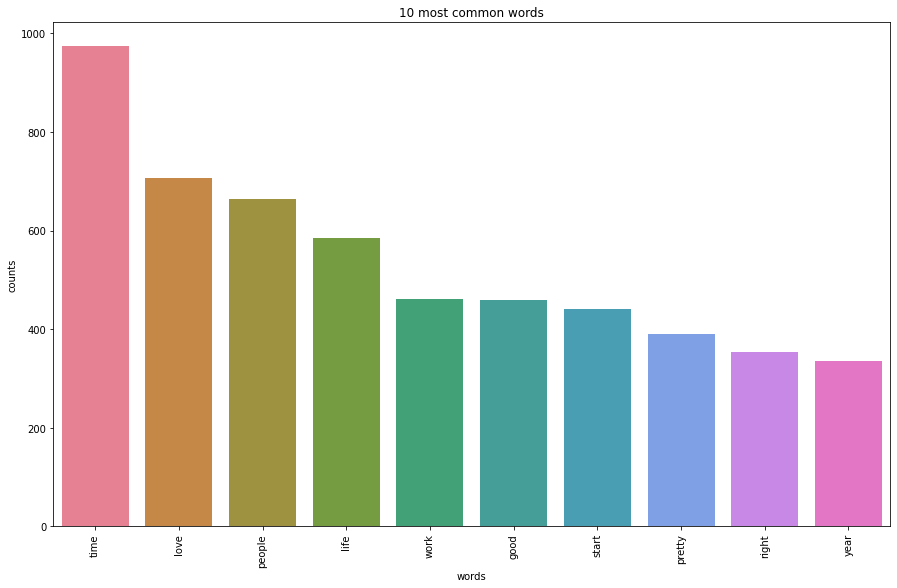

In [37]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialisation of the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transformation of the processed titles
count_data = count_vectorizer.fit_transform(training_data_preprocessed['Input'])
tf = count_data

# Visualization of the 10 most common words (bar chart)
plot_10_most_common_words(tf, count_vectorizer)

In [76]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
#number of topics = 6       
number_topics = 6

#number of words = 10
number_words = 10

# Creation and fit of the LDA model
lda = LDA(n_components=number_topics)
lda.fit(tf)

# Print  topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)



Topics found via LDA:

Topic #0:
love people life time care want work mean content post

Topic #1:
work passionate room lose vulnerable right write heart moment remember

Topic #2:
leave time week pretty start sure write right afraid begin

Topic #3:
time happy tell hate people morning bless person help good

Topic #4:
year life miss time school hurt love start hear work

Topic #5:
today friend good pretty start time quite stop write stress


In [77]:
transformed_test_data = count_vectorizer.transform(test_data_preprocessed)
print(transformed_test_data)

  (0, 5088)	1
  (1, 8773)	1


In [78]:
lda.transform(transformed_test_data)

array([[0.08422269, 0.58133937, 0.08443008, 0.0833362 , 0.08333583,
        0.08333583],
       [0.58331383, 0.08333789, 0.08333702, 0.0833372 , 0.08333704,
        0.08333703]])

In [58]:
# log-likelihood score
print(lda.score(tf))

-736693.9691746548


In [59]:
# perplexity score
print(lda.perplexity(tf))

5046.01044857662


In [60]:
#visualisation plydavis
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
LDAvis_prepared

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.041044 -0.022913       1        1  18.837584
4     -0.005830 -0.038370       2        1  18.070738
0     -0.034816  0.146641       3        1  16.320963
1     -0.171771 -0.020174       4        1  15.959095
2      0.045158 -0.130574       5        1  15.600770
3      0.126215  0.065391       6        1  15.210850, topic_info=          Term        Freq       Total Category  logprob  loglift
7274    people  589.000000  589.000000  Default  30.0000  30.0000
9423     start  389.000000  389.000000  Default  29.0000  29.0000
10084     time  863.000000  863.000000  Default  28.0000  28.0000
5933      love  625.000000  625.000000  Default  27.0000  27.0000
11155    world  181.000000  181.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
8377     right   63.373655  313.608621   Topic6  -5.3346   0.2841
5842      live   48.194047  148.756255   Topic6  -5.6084   0.7561
890    believe   39.425738  103.643359   Topic6  -5.8092   0.9166
4581      help   42.829576  295.330590   Topic6  -5.7264  -0.0477
10018    think   39.268820  200.907011   Topic6  -5.8132   0.2507

[420 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
51         1  0.109942    accept
51         2  0.009995    accept
51         6  0.879534    accept
116        1  0.054881  actually
116        2  0.203058  actually
...      ...       ...       ...
11246      1  0.059879     young
11246      3  0.079839     young
11246      4  0.798391     young
11246      5  0.039920     young
11281      6  0.941327      zoom

[895 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 2, 3, 4])

In [79]:
words = count_vectorizer.get_feature_names()

def create_a_word_cloud(i):
    topic_words = ""
    components = lda.components_[i]
    words_components = zip(words, components)
    words_sorted = sorted(words_components, key = lambda x:x[1], reverse =True)[:15] #15 words per word cloud
    for word in words_sorted:
        topic_words = topic_words+" "+word[0]

    wordcloud = WordCloud(background_color='white', width = 550, height = 350).generate(topic_words)
    plt.figure( figsize =(5,5)) #figure size
    plt.imshow(wordcloud)
    plt.axis("off") #no axis
    plt.tight_layout()
    plt.show()
 

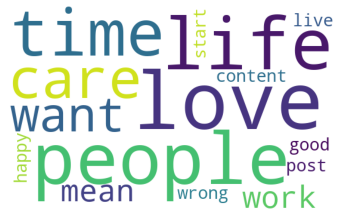

In [80]:
#word cloud for topic 0
create_a_word_cloud(0)

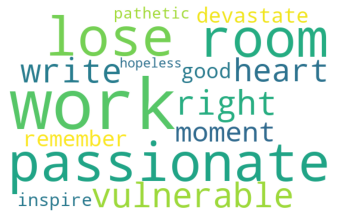

In [81]:
#word cloud for topic 1
create_a_word_cloud(1)

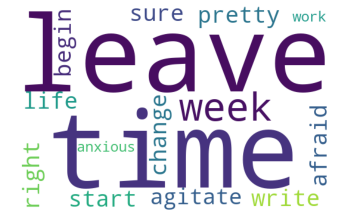

In [82]:
#word cloud for topic 2
create_a_word_cloud(2)

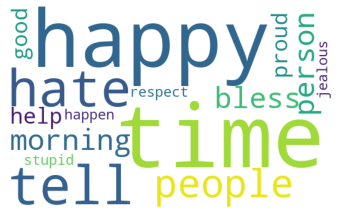

In [83]:
#word cloud for topic 3
create_a_word_cloud(3)

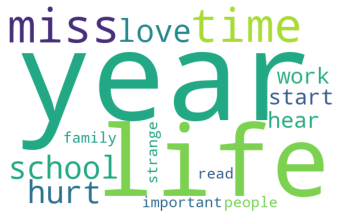

In [84]:
#word cloud for topic 4
create_a_word_cloud(4)

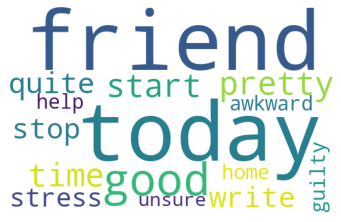

In [85]:
#word cloud for topic 5
create_a_word_cloud(5)

# Sentiment Analysis 

In this section the sentiment analysis will be performed on the dataset


In [ ]:
#!pip install simpletransformers

In [29]:
import simpletransformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs

     |████████████████████████████████| 249 kB 5.1 MB/s 
     |████████████████████████████████| 1.8 MB 49.5 MB/s 
     |████████████████████████████████| 10.1 MB 14.0 MB/s 
     |████████████████████████████████| 4.0 MB 35.1 MB/s 
     |████████████████████████████████| 325 kB 47.5 MB/s 
     |████████████████████████████████| 6.5 MB 40.8 MB/s 
     |████████████████████████████████| 1.2 MB 38.2 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 47.9 MB/s 
     |████████████████████████████████| 144 kB 48.6 MB/s 
     |████████████████████████████████| 181 kB 37.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 212 kB 35.4 MB/s 
     |████████████████████████████████| 136 kB 46.8 MB/s 
     |████████████████████████████████| 1.1 MB 32.7 MB/s 
     |██████████████

In [30]:
training_data_preprocessed.head()

,Input,Sentiment
0,humiliate,0
1,feeling hopeless damn hopeful around someone c...,0
2,grab minute post greedy wrong,4
3,ever feel nostalgic fireplace still property,3
4,feel grouchy,4


# RoBERTa transfer model for sentiment analysis

In [31]:
#Fine-tuning of the transformer-based pretrained language model RoBERTa

model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model (eval data should be passed to the training method)
model_args.num_train_epochs=1 # number of epochs
model_args.train_batch_size= 16 # batch size
model_args.learning_rate=3e-5 # learning rate
model_args.max_seq_length=256




# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=40 # how often you want to run validation in terms of training steps (or batches)


In [32]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(training_data_preprocessed) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 34 steps * 2 (validating 2 times per epoch)

Each epoch will have 997 steps.


In [33]:
#model

model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels = 6,
        use_cuda=True,
        args=model_args,)



Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [34]:
print(str(model.args).replace(',', '\n')) # model args

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=8
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=40
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=3e-05
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_seed=None
 max_grad_norm=1.0
 

In [35]:
#train model

import torch
torch.cuda.empty_cache()
_, history = model.train_model(training_data_preprocessed, eval_df=validation_data_preprocessed) 

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/15938 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/997 [00:01<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

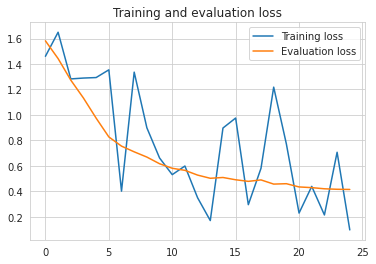

In [36]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [37]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(validation_data_preprocessed)
result

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.4151859588623047, 'mcc': 0.825101353422466}

# User output: Get dataframe with sentences only containing the word "Work"

In [38]:
word = "work" #select the word "work"
list_to_remove = []

for sentence in test_data_preprocessed['Input']:
  index = (test_data_preprocessed[test_data_preprocessed["Input"]==sentence].index.values)
  if not(word in sentence):
      # print(sentence)
      for i in index: 
        # print(sentence)
        list_to_remove.append(i)
# print(list_to_remove)

In [39]:
test_data_preprocessed = test_data_preprocessed.drop(labels=list_to_remove, axis=0, inplace=False)
# training_data_preprocessed.head()
len(test_data_preprocessed.index)

71

In [40]:
predicted, probabilities = model.predict(test_data_preprocessed.Input.tolist())
test_data_preprocessed['predicted'] = predicted

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [41]:
#check out the predictions 
test_data_preprocessed.head(5)

,Input,Sentiment,predicted
49,feel pretty anxious first work good help,5,5
55,would like girl friends never work ever emotio...,0,0
65,stun imagine folk work studio morning feeling,2,2
135,control growth business every time post work c...,1,1
146,feel eager start work work literally back find...,1,1


In [42]:
#check out the predictions 
test_data_preprocessed.head(5)

,Input,Sentiment,predicted
49,feel pretty anxious first work good help,5,5
55,would like girl friends never work ever emotio...,0,0
65,stun imagine folk work studio morning feeling,2,2
135,control growth business every time post work c...,1,1
146,feel eager start work work literally back find...,1,1


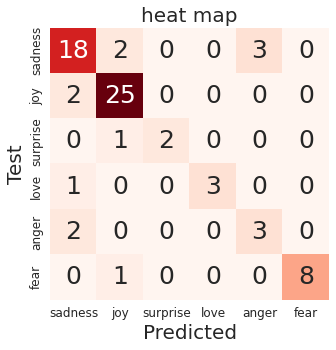

	Classification Report for BERT:

               precision    recall  f1-score   support

     sadness       0.78      0.78      0.78        23
         joy       0.86      0.93      0.89        27
    surprise       1.00      0.67      0.80         3
        love       1.00      0.75      0.86         4
       anger       0.50      0.60      0.55         5
        fear       1.00      0.89      0.94         9

    accuracy                           0.83        71
   macro avg       0.86      0.77      0.80        71
weighted avg       0.84      0.83      0.83        71



In [43]:
#print confusion matrix

def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['sadness', 'joy', 'surprise','love','anger', 'fear']
    ax=sns.heatmap(confusion_matrix(test_data_preprocessed['Sentiment'], test_data_preprocessed['predicted']), annot=True, cmap="Reds", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=12) 
    ax.yaxis.set_ticklabels(labels, fontsize=12)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

conf_matrix(test_data_preprocessed['Sentiment'], test_data_preprocessed['predicted'], 'heat map')
from sklearn.metrics import classification_report

#print classification report
print('\tClassification Report for BERT:\n\n',classification_report(test_data_preprocessed['Sentiment'],test_data_preprocessed['predicted'], target_names=['sadness', 'joy', 'surprise','love','anger', 'fear']))


In [44]:
#see the prediction and actual value of the sentences that contain the word "work"

test_data_preprocessed

,Input,Sentiment,predicted
49,feel pretty anxious first work good help,5,5
55,would like girl friends never work ever emotio...,0,0
65,stun imagine folk work studio morning feeling,2,2
135,control growth business every time post work c...,1,1
146,feel eager start work work literally back find...,1,1
...,...,...,...
1871,gift book feel intimidated take intricate work,5,5
1885,work half voice caleb wonderful night comus,1,1
1889,leave work complicate tempered disquiet future...,3,0
1970,guess table policy discussion work fight chang...,3,3


# The End